In [203]:
!pip install geopy

     |████████████████████████████████| 112 kB 5.5 MB/s eta 0:00:01


In [248]:
import os
import json
import time
import pandas as pd
import datetime
import rasterio
from matplotlib import pyplot as plt
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from os import path
import h5py
import geopy.distance

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

gauth = GoogleAuth()
# Try to load saved client credentials
gauth.LoadCredentialsFile("mycreds.txt")
if gauth.credentials is None:
    # Authenticate if they're not there
    gauth.LocalWebserverAuth()
elif gauth.access_token_expired:
    # Refresh them if expired
    gauth.Refresh()
else:
    # Initialize the saved creds
    gauth.Authorize()
# Save the current credentials to a file
gauth.SaveCredentialsFile("mycreds.txt")

drive = GoogleDrive(gauth)

In [247]:
# set params
tile_height, tile_length = (64, 64)
examples_per_save_file = 1000
composite_file_name = 'bangladesh_all_bands_final'
download_all_first = False

save_path = '/atlas/u/mhelabd/data/kiln-scaling/tiles/'
composite_save_path = '/atlas/u/mhelabd/data/kiln-scaling/composites/'

# save_path = '../data/tiles_hdf5/'
# composite_save_path = '../data/composites/'

# resources
kilns = pd.read_csv("../data/bangladesh_kilns.csv")
all_bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B8', 'B9', 'B10', 'B11', 'B12']

print(kilns.head())

   index        lat        lon     x    y      prob prediction   shape
0      0  23.796287  90.316715  1043  518  0.564438     zigzag  zigzag
1      1  23.940202  90.043026    78  149  0.692853     zigzag  zigzag
2      2  25.021253  89.309124   636  327  0.499505        fck     fck
3      3  25.308184  89.550603    97   85  0.342437        fck  zigzag
4      4  22.561670  92.007151   145  175  0.922128     zigzag  zigzag


In [5]:
file_list = drive.ListFile({'q': "title contains '" + composite_file_name + "'"}).GetList()
print("Found " + str(len(file_list)) + " files")
file_list = sorted(file_list, key=lambda file: file['title'])
for file in file_list[:5]:
  print('title: %s, id: %s' % (file['title'], file['id']))

Found 80 files
title: bangladesh_all_bands_final-0000000000-0000000000.tif, id: 1ZHtyKejLTVvFo5s1Ui--sA_RqKBtfZlZ
title: bangladesh_all_bands_final-0000000000-0000006656.tif, id: 1GlKU0_kZEaisJ8sBWGsl7VNg9pwsPD8Z
title: bangladesh_all_bands_final-0000000000-0000013312.tif, id: 1Wm1kJeH2zQ42bNEuqDbSLcR_vP-KEu6_
title: bangladesh_all_bands_final-0000000000-0000019968.tif, id: 1RkLg2pzmr9QkVg8NmfPhKVbPGAtxkfKH
title: bangladesh_all_bands_final-0000000000-0000026624.tif, id: 1YCQxQ6WzZQTwpEKY7IeW1lWbCBYcUN2l


In [6]:
# calculate image grid
first_x_coord = file_list[0]['title'].split(".")[0].split("-")[1]
first_y_coord = file_list[0]['title'].split(".")[0].split("-")[2]
num_image_cols = len([x for x in file_list if x['title'].split(".")[0].split("-")[1] == first_x_coord])
num_image_rows = len([x for x in file_list if x['title'].split(".")[0].split("-")[2] == first_y_coord])
print("Number of image grid columns:", num_image_cols)
print("Number of image grid rows:", num_image_rows)

Number of image grid columns: 8
Number of image grid rows: 10


In [92]:
coords = []
with open("../data/countries.geojson", "r") as countries_geojson:
    country_dict = json.load(countries_geojson)["features"]
for obj in country_dict:
    name = obj['properties']['ADMIN']
    if name == "Bangladesh":
        coords = obj['geometry']["coordinates"]
flat_coords = []
for sublist in coords:
    for coord in sublist:
        for c in coord:
            flat_coords.append(c)
            
flat_coords += [flat_coords[0]]
bangladesh_geo = Polygon(flat_coords)

In [93]:
# optional pre-download all files
if download_all_first:
    for file in file_list:
        start_time = time.time()
        composite_file_path = composite_save_path + file['title']
        if path.exists(composite_file_path):
            print("File already downloaded.")
        else:
            print("Downloading file...")
            # download the file
            download_file = drive.CreateFile({'id': file['id']})
            file.GetContentFile(composite_file_path)
            print("Finished file in " + str(time.time() - start_time))
    print("Done downloading all files.")

In [228]:
def get_bands_and_bounds_from_file(file):
    print("Starting file " + file['title'])
    composite_file_path = composite_save_path + file['title']
    if path.exists(composite_file_path):
        print("File already downloaded.")
    else:
        print("Downloading file...")
        # download the file
        download_file = drive.CreateFile({'id': file['id']})
        file.GetContentFile(composite_file_path)
    
    # open file with rasterio
    print("Reading file...")
    dataset = rasterio.open(composite_file_path)
    bands = dataset.read()
    print("Done processing file")
    return bands, dataset.bounds

def get_data_and_bounds_given_pixels(ds_bounds, bands, start_row, start_col, contains_kiln):
    global num_tiles_dropped
    
    num_bands, ds_height, ds_length = bands.shape
    tile_top = ds_bounds.top - (start_row / ds_height) * (ds_bounds.top - ds_bounds.bottom)
    tile_bottom = ds_bounds.top - ((start_row + tile_height) / ds_height) * (ds_bounds.top - ds_bounds.bottom)
    tile_left = ds_bounds.left + (start_col / ds_length) * (ds_bounds.right - ds_bounds.left)
    tile_right = ds_bounds.left + ((start_col + tile_length) / ds_length) * (ds_bounds.right - ds_bounds.left)
    bounds = np.array([tile_bottom, tile_left, tile_top, tile_right])
    tile_geo = Polygon([[tile_left, tile_top], [tile_right, tile_top], [tile_right, tile_bottom], [tile_left, tile_bottom], [tile_left, tile_top]])
    if not contains_kiln and not bangladesh_geo.intersects(tile_geo):
        num_tiles_dropped += 1
        return None, None
    return bands[:, start_row : start_row + tile_height, start_col : start_col + tile_length], bounds

def save_current_file(save_index, counter):
    filename = save_path + "examples_" + str(save_index) + ".hdf5"
    print("Saving file", filename)
    f = h5py.File(filename, 'w')
    bounds_dset = f.create_dataset("bounds", data=tile_bounds[:counter])
    examples_dset = f.create_dataset("images", data=examples[:counter])
    labels_dset = f.create_dataset("labels", data=labels[:counter])
    f.close()
    return save_index + 1, 0

def add_example(ex_data, ex_bounds, save_index, counter, is_positive):
    tile_bounds[counter] = ex_bounds
    examples[counter] = ex_data
    labels[counter] = 1 if is_positive else 0
    new_counter = counter + 1
    
    if new_counter == examples_per_save_file:
        return save_current_file(save_index, counter)
    return save_index, new_counter

def get_kiln_tiles_approx_coords(bounds, num_rows, num_cols):
    kilns_in_image = kilns.loc[(kilns['lat'] >= bounds['bottom']) & (kilns['lat'] <= bounds['top']) 
        & (kilns['lon'] >= bounds['left']) & (kilns['lon'] <= bounds['right'])]
    
    tiles = set()
    for index, kiln in kilns_in_image.iterrows():
        kiln_pos = (kiln['lat'], kiln['lon'])
        kiln_to_top = geopy.distance.geodesic(kiln_pos, (bounds['top'], kiln_pos[1])).km
        kiln_to_bottom = geopy.distance.geodesic(kiln_pos, (bounds['bottom'], kiln_pos[1])).km
        row_index = int(kiln_to_top / (kiln_to_top + kiln_to_bottom) * num_rows)
        
        kiln_to_left = geopy.distance.geodesic(kiln_pos, (kiln_pos[0], bounds['left'])).km
        kiln_to_right = geopy.distance.geodesic(kiln_pos, (kiln_pos[0], bounds['right'])).km
        col_index = int(kiln_to_left / (kiln_to_left + kiln_to_right) * num_cols)
        tiles.add((row_index, col_index))
    
    return tiles

In [126]:
# image is a single example of shape (13, 64, 64)
def visualize_tile(image, indices=[3, 2, 1]):
    row_idx = np.array(indices)
    X = np.transpose(image[row_idx], (1, 2, 0))
    X *= 1 / np.max(X)
    print(X.shape)
    plt.imshow(X)
    
def pretty_bounds(bounds):
    return [[bounds[1], bounds[0]], [bounds[1], bounds[2]], [bounds[3], bounds[2]], [bounds[3], bounds[0]], [bounds[1], bounds[0]]]

<Figure size 432x288 with 0 Axes>

In [245]:
# testing variables
num_tiles_dropped = 0
# num_pos_examples_found = 0
# found_pos_image = False
pos_examples = []

save_index, counter = 0, 0

tile_bounds = np.zeros([examples_per_save_file, 4])
examples = np.zeros([examples_per_save_file, len(all_bands), tile_height, tile_length])
labels = np.zeros([examples_per_save_file, 1])

In [233]:
file_list = file_list[:1] # testing purposes

total_start_time = time.time()
for index, file in enumerate(file_list):
    file_start_time = time.time()
    bands, ds_bounds = get_bands_and_bounds_from_file(file)
    
    num_bands, ds_height, ds_length = bands.shape
    num_rows = ds_height // tile_height
    num_cols = ds_length // tile_length

    bounds = {
        "bottom": ds_bounds.bottom,
        "top": ds_bounds.top,
        "left": ds_bounds.left,
        "right": ds_bounds.right
    }

    row_px_excess, col_px_excess = None, None
    percent_row_excess, percent_col_excess = None, None

    if index % num_image_cols == num_image_cols - 1: # rightmost column
        # calculate excess col pixels
        col_px_excess = ds_length % tile_length
        bounds["right"] -= col_px_excess / ds_length * (ds_bounds.right - ds_bounds.left)

    if index // num_image_cols == num_image_rows - 1: # last row
        # calculate excess row pixels
        row_px_excess = ds_height % tile_height
        bounds["bottom"] += row_px_excess / ds_height * (ds_bounds.top - ds_bounds.bottom)

#     kiln_tiles = get_kiln_tiles(bounds, num_rows, num_cols)
    kiln_tiles = get_kiln_tiles_approx_coords(bounds, num_rows, num_cols)
    print("Num tiles with kilns:", len(kiln_tiles))
    print(kiln_tiles)

    print("Tiling dataset...")
    for tile_idx_row in range(0, num_rows):
        px_row = tile_idx_row * tile_height
        for tile_idx_col in range(0, num_cols):
            px_col = tile_idx_col * tile_length
            tile_has_kiln = (tile_idx_row, tile_idx_col) in kiln_tiles
            data, data_bounds = get_data_and_bounds_given_pixels(ds_bounds, bands, px_row, px_col, tile_has_kiln)
            if data is not None:
                save_index, counter = add_example(data, data_bounds, save_index, counter, tile_has_kiln)
                if tile_has_kiln:
                    print("index", (tile_idx_row, tile_idx_col))
                    print("bounds", pretty_bounds(data_bounds))
                    pos_examples += [data]

    # TODO: handle leftovers
    if index == len(file_list) - 1:
        save_current_file(save_index, counter)

    print("Total tiles dropped (outside country):", num_tiles_dropped)
    print("Total tiles kept:", str(num_rows * num_cols - num_tiles_dropped))
    num_tiles_dropped = 0
    print("Finished file in", time.time() - file_start_time, "\n")
print("Finished " + str(len(file_list)) + " files in: " + str(time.time() - total_start_time))

Starting file bangladesh_all_bands_final-0000000000-0000000000.tif
File already downloaded.
Reading file...
Done processing file
Num tiles with kilns: 11
{(95, 75), (98, 76), (71, 91), (67, 58), (71, 90), (98, 78), (91, 45), (99, 73), (78, 60), (99, 72), (97, 76)}
Tiling dataset...
Saving file ../data/tiles_hdf5/examples_0.hdf5
index (67, 58)
bounds [[88.35523707403013, 26.232602926858267], [88.35523707403013, 26.238352144676632], [88.36098629184849, 26.238352144676632], [88.36098629184849, 26.232602926858267], [88.35523707403013, 26.232602926858267]]
Saving file ../data/tiles_hdf5/examples_1.hdf5
index (71, 90)
bounds [[88.5392120442178, 26.209606055584807], [88.5392120442178, 26.215355273403173], [88.54496126203617, 26.215355273403173], [88.54496126203617, 26.209606055584807], [88.5392120442178, 26.209606055584807]]
index (71, 91)
bounds [[88.54496126203617, 26.209606055584807], [88.54496126203617, 26.215355273403173], [88.55071047985454, 26.215355273403173], [88.55071047985454, 26.2

In [ ]:
# f = h5py.File('../data/tiles_hdf5/examples_0.hdf5','r')
# print("all keys", f.keys())
# print(f['images'].shape)
# print(f['bounds'].shape)
# print(f['labels'].shape)

In [236]:
# lats = pixel_lats[0]
# longs = pixel_longs[:, 0]
# 
# print(lats)
# print(pos_examples[0])

In [219]:
# print(examples[0][0].shape)
print(tile_bounds[0])
print(tile_bounds[1])
print(tile_bounds[2])

[26.07162483 88.48746908 26.07737405 88.4932183 ]
[26.07162483 88.4932183  26.07737405 88.49896752]
[26.07162483 88.49896752 26.07737405 88.50471674]


(64, 64, 3)


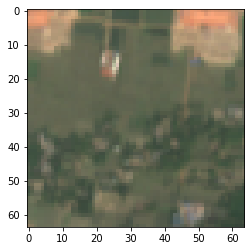

In [244]:
visualize_tile(pos_examples[10])
# visualize_tile(examples[1])
# visualize_tile(examples[2])

In [114]:
print(bangladesh_geo.intersects(Polygon([
            [
              88.38398316,
              26.6120513
            ],
            [
              88.38973238,
              26.6120513
            ],
            [
              88.38973238,
              26.61780052
            ],
            [
              88.38398316,
              26.61780052
            ],
            [
              88.38398316,
              26.6120513
            ]
          ])))

True


In [106]:
print(bangladesh_geo.area)
print(Polygon([
            [
              88.38398316,
              26.6120513
            ],
            [
              88.38973238,
              26.6120513
            ],
            [
              88.38973238,
              26.61780052
            ],
            [
              88.38398316,
              26.61780052
            ],
            [
              88.38398316,
              26.6120513
            ]
          ]).area)

13.698944042796395
3.305353060838212e-05


## Next Steps
* check tile labeling
  * print out tile row/col indices
  * check order that tiles are iterating
* print multiple images in one cell